<a href="https://colab.research.google.com/github/AraiKensuke/FitSpectrum/blob/master/FitPowerSpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'd like to assess whether a continuous signal contains 1 or more oscillatory components.  The power spectral density is used to assess the relative signal strength at various frequencies.  However, there is no definitive test we can use to say an oscillation at a certain frequency exists.  This is complicated by nonstationarity and spectral width of oscillations (ie oscillation is not a sine wave) present.  We therefore propose modeling the PSD as having a 1/f dependence with some peaks at certain frequency bands.  We impose our beliefs about components via priors on model parameters.  We use the pymc3 Monte Carlo Bayesian posterior inference package, which compared to a traditional Gibbs sampler where we must be careful about the choice of priors if we wish to keep the problem easy by being able to sample from known classes of distributions, allows us to specify any class of distribution to better 

# Install multitaper PSD, arviz, FitSpectrum

In [ ]:
!pip install nitime              #  
!pip install arviz==0.5.1        # pymc3 on Colab is v3.7.  We need old version of arviz

import sys
import importlib

if importlib.util.find_spec("FitSpectrum") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/FitSpectrum.git

sys.path.insert(1, "/content/FitSpectrum")
import FitSpectrum.buildsignal as bs

import pymc3 as pm
import numpy as _N
import matplotlib.pyplot as plt; plt.ion()




# Install LOST for AR decomposition, a complimentary time-series approach

Another complimentary approach is to model directly the timeseries as an AR(p) process.  The AR(p) can be decomposed into $C$ AR(2) and $R$ AR(1) components.  AR(2) models can be quasi oscillatory, while AR(1) cannot be.  

In [ ]:
if importlib.util.find_spec("LOST") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/LOST.git
  %cd /content/LOST

!python setup.py build_ext --inplace   #  don't need to compile for this notebook

sys.path.insert(1, "/content/LOST")    #  add these to searchpath for python modules

# Example of simulated EEG using AR($p$), generated by specifying $R$ AR(1) and $C$ AR(2) components

(1.0, 55.0)

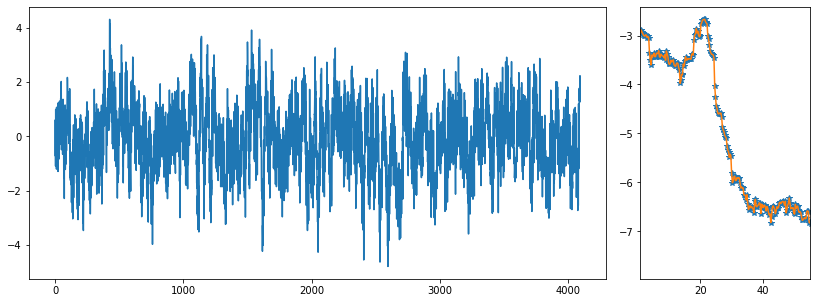

In [ ]:
import FitSpectrum.buildsignal as bs       #
import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate

_N.random.seed(1000)   #  set the random seed.

###  Specify the signal 
f1=21.   # hz
coh1=0.982   # how coherent or sinusoidal is f1 osc?  0~1    1 near sinusoidal, > 0.95 neural-like

obs_nz    = 0.8   #  make this bigger to add more observation noise
comps         = [[[f1, coh1]], [0.96]]      #  describe AR(p) in terms of AR(2) and AR(1) components.
N             = 4096
dt            = 0.001
#  
signal         = bs.build_signal(N, dt, [comps], [1])  
signal         += obs_nz*_N.random.randn(N)    #  add observation noise (white noise)


fig = plt.figure(figsize=(14, 5))
plt.subplot2grid((1, 4), (0, 0), colspan=3)
plt.plot(signal)
plt.subplot2grid((1, 4), (0, 3), colspan=1)
# multi-taper: for now, let's work on the average of tapers
# focus on 1 to 30 Hz
bw = 9
f, psd_mt, nu = tsa.multi_taper_psd(signal,Fs=1/dt, NW=bw , low_bias=False, adaptive=False, jackknife=False)
plt.plot(f,_N.log(psd_mt),'*')
plt.plot(f, _N.log(psd_mt))
plt.xlim(1,55)

theseInds = _N.where(f < 55)[0]
f_psd     = f[theseInds]

# Fit the spectrum of simulated EEG

We fit a model on to PSD($f$).  Model form is $\mbox{log PSD}(f) = \sum_c^{N_c} w_c \exp\left[-\frac{(f-\mu_c)^2}{2\sigma_c^2}\right] + \frac{a}{f + b} + c$.  We fix $N_c$.  The prior for the $w_c$, $\sigma_c$ and $a$ are HalfNormal, which keeps it $\geq 0$.  Priors on centers $\mu_c$ are normally distributed (though we could also have chosen them to be a rectified distribution), as are for the $b$ and $c$.  Note that when we specify the prior for each component, the distribution itself has parameters, ie *hyperparameters*.  For example, for $\mu_c$, we specified the hyperparameters of the priors, the center and width, using`mu=` and `sigma=`.

In [ ]:
####  fit to PYMC3 model using posterior sampling.
####  model assumes up to 3 bumps in power spectrum
def do_fit_psd(f_at_obs, log_psd):
  # # define the model/function to be fitted.

  with pm.Model() as model3:
    #  SPECIFY prior distributions for parameters
    #  weigts
    w1 = pm.HalfNormal('w1', sigma=1)
    w2 = pm.HalfNormal('w2', sigma=1)
    w3 = pm.HalfNormal('w3', sigma=1)
    sig1 = pm.HalfNormal('sig1', sigma=2)
    sig2 = pm.HalfNormal('sig2', sigma=2)
    sig3= pm.HalfNormal('sig3', sigma=2)
    mu1 = pm.Normal('mu1', mu=1, sigma=5)   #  initialize w/ diff values
    mu2 = pm.Normal('mu2', mu=15, sigma=5)
    mu3 = pm.Normal('mu3', mu=30, sigma=5)
    a = pm.HalfNormal('a', 20)
    b = pm.Normal('b', 0.13, 40)
    c = pm.Normal('c', mu=0., sigma=4)

    error = pm.HalfNormal("error", sigma=0.3)
    ####  Gaussian noise assumed on top of a/(f+b) shape
    gauss=pm.Deterministic('gauss',w1*_N.exp(-0.5*(f_at_obs-mu1)**2/(sig1**2))+w2*_N.exp(-0.5*(f_at_obs-mu2)**2/(sig2**2))+w3*_N.exp(-0.5*(f_at_obs-mu3)**2/(sig3**2))+a/(f_at_obs+b) + c)

    y =pm.Normal('y', mu=gauss, sigma=error, observed=log_psd)

    #map_estimate=pm.find_MAP()    #  can also do point MAP estimate 
    step=pm.NUTS()
    trace=pm.sample(2000)

  return trace, model3

Now we run the model fit using pymc3.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, c, b, a, mu3, mu2, mu1, width3, width2, width1, amp3, amp2, amp1]
100%|██████████| 2500/2500 [01:56<00:00, 21.38it/s]
There were 493 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5036347392092098, but should be close to 0.8. Try to increase the number of tuning steps.
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


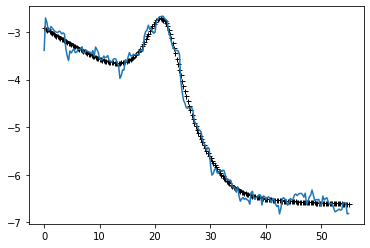

In [ ]:
trace, modelsim = do_fit_psd(f_psd, _N.log(psd_mt[theseInds]))
y_fit = _N.percentile(trace.gauss,50,axis=0)
plt.plot(f_psd, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(f_psd, _N.log(psd_mt[theseInds]))

**Look at Gibbs samples and marginal posterior distributions of parameters**



# Look at marginal posteriors of each component

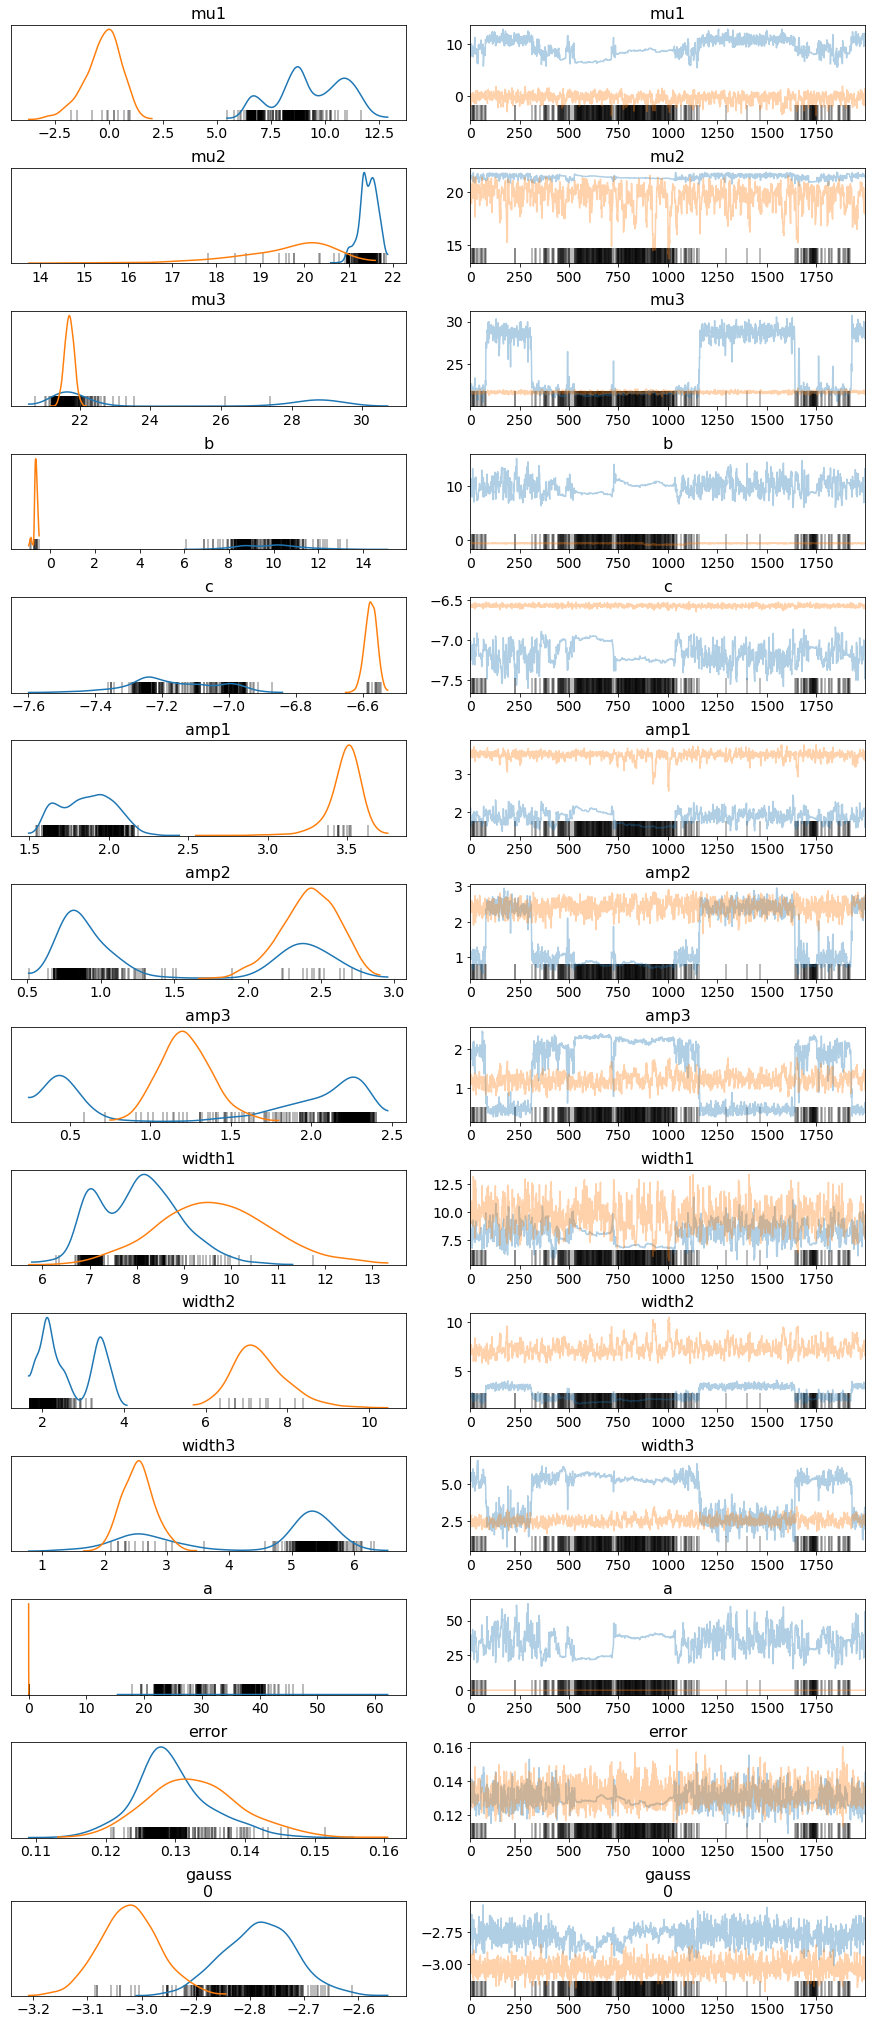

In [ ]:
import arviz as az
with modelsim:
    az.plot_trace(trace);

**Now let's load some actual EEG data recorded while a subject closed and then openned their eyes for about 15 seconds.**
There is a clear qualitative difference in the way the EEG looks.

# human EEG of eyes open then closed

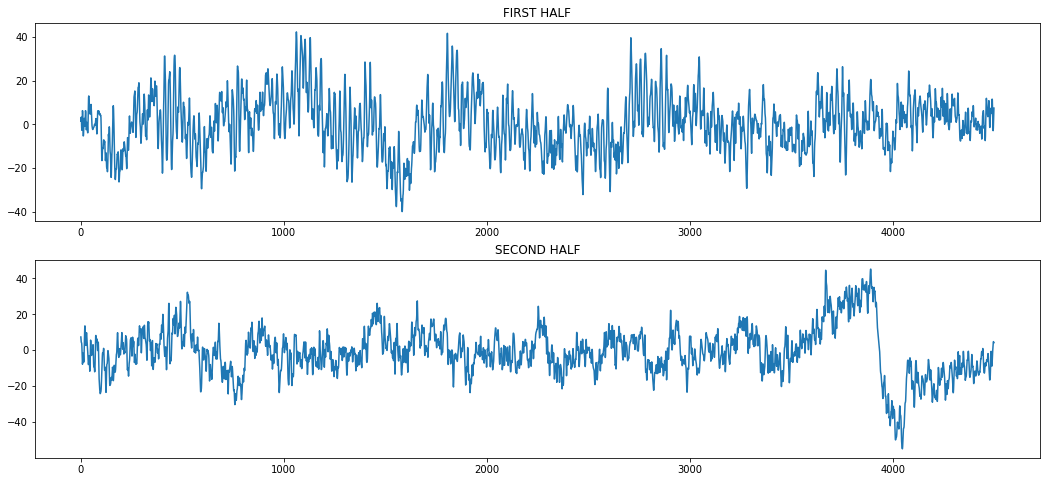

In [ ]:
eeg_channel = 0
fig = plt.figure(figsize=(18, 8))
fig.add_subplot(2, 1, 1)
plt.title("FIRST HALF")
plt.plot(eeg[0:4500, eeg_channel])
fig.add_subplot(2, 1, 2)
plt.title("SECOND HALF")
plt.plot(eeg[4500:, eeg_channel])

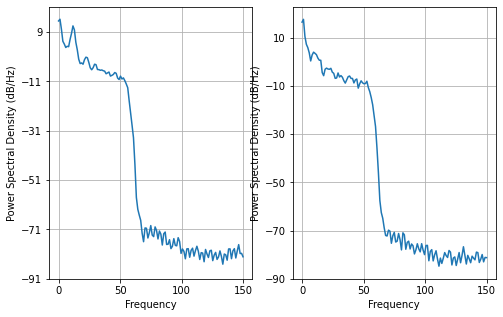

In [ ]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(1, 2, 1)
eeg_psd1, eeg_f_psd1 = plt.psd(eeg[0:4500, eeg_channel], Fs=300)
fig.add_subplot(1, 2, 2)
eeg_psd2, eeg_f_psd2 = plt.psd(eeg[4500:, eeg_channel], Fs=300)

# Fitting human EEG of eyes closed

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, c, b, a, mu3, mu2, mu1, width3, width2, width1, amp3, amp2, amp1]
100%|██████████| 2500/2500 [00:53<00:00, 46.67it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


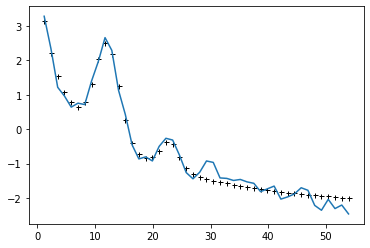

In [ ]:
theseInds = _N.where((eeg_f_psd1 < 55) & (eeg_f_psd1 > 0))[0]

trace1, model = do_fit_psd(eeg_f_psd1[theseInds], _N.log(eeg_psd1[theseInds]))
y_fit = _N.percentile(trace1.gauss,50,axis=0)
plt.plot(eeg_f_psd1[theseInds], y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(eeg_f_psd1[theseInds], _N.log(eeg_psd1[theseInds]))

# Fitting human EEG of eyes open

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [error, c, b, a, mu3, mu2, mu1, width3, width2, width1, amp3, amp2, amp1]
100%|██████████| 2500/2500 [00:39<00:00, 64.04it/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


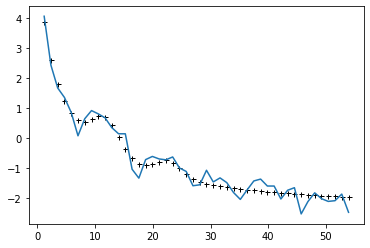

In [ ]:
theseInds = _N.where((eeg_f_psd2 < 55) & (eeg_f_psd2 > 0))[0]

trace2, model2 = do_fit_psd(eeg_f_psd2[theseInds], _N.log(eeg_psd2[theseInds]))
y_fit = _N.percentile(trace2.gauss,50,axis=0)
plt.plot(eeg_f_psd2[theseInds], y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.plot(eeg_f_psd2[theseInds], _N.log(eeg_psd2[theseInds]))

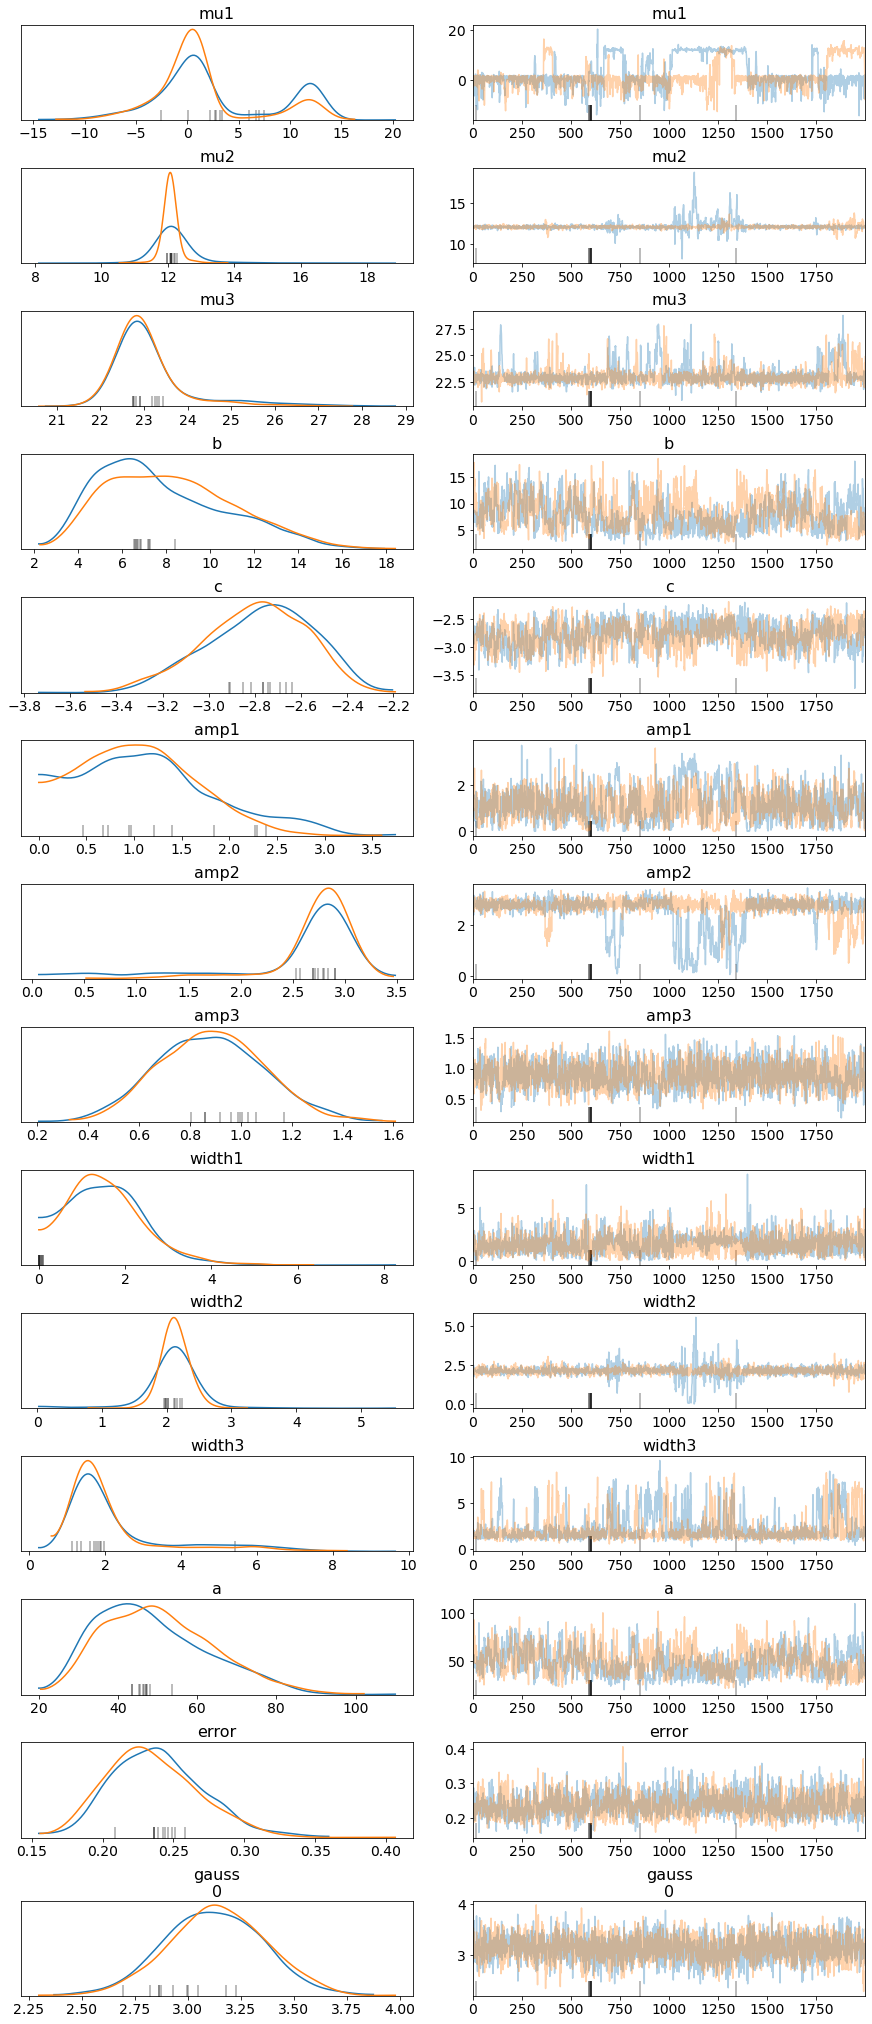

In [ ]:

import arviz as az
with pm.Model() as model:
    az.plot_trace(trace1);

# AR decomposition on oscillatory EEG


**For comparison, we take another appproach. We fit the time-domain signal using an AR($p$) model, and do a time-domain decomposition of the signal into AR(1) and AR(2) components.**


In [ ]:
import LOST.mcmcARcontinuous as _mcarc

Fs         = 300
C          = 12
R          = 1
ch         = 9
N          = 2048   #  how much data to use

mcarc1 = _mcarc.mcmcARcontinuous(Fs, C, R)

#eeg[0:4500, eeg_channel]
#eeg = _N.loadtxt(datfn)

ITER=8000
obsvd = eeg[0:4500, eeg_channel]
obsvd = obsvd.reshape((1, 4500))
skp = 10
mcarc1.gibbsSamp(N, ITER, obsvd, skp=skp, peek=1000)

allfs1   = mcarc1.fs[ITER//(2*skp):].flatten()
allamps1 = mcarc1.amps[ITER//(2*skp):].flatten()




In [ ]:
fig = plt.figure()
plt.scatter(allfs1[500:], allamps1[500:], s=3)
plt.xlabel("frequency of root")
plt.ylabel("modulus")


# AR decomposition on non-oscillatory EEG

In [ ]:
Fs         = 300
C          = 12
R          = 1
ch         = 9
N          = 2048   #  how much data to use

mcarc2 = _mcarc.mcmcARcontinuous(Fs, C, R)

#eeg[0:4500, eeg_channel]
#eeg = _N.loadtxt(datfn)

ITER=8000
obsvd = eeg[0:4500, eeg_channel]
obsvd = obsvd.reshape((1, 4500))
skp = 10
mcarc2.gibbsSamp(N, ITER, obsvd, skp=skp, peek=1000)

allfs2   = mcarc2.fs[ITER//(2*skp):].flatten()
allamps2 = mcarc2.amps[ITER//(2*skp):].flatten()



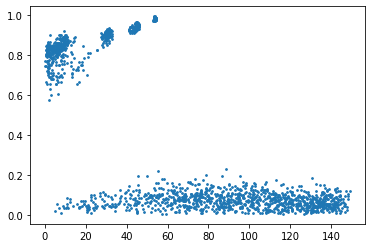

In [ ]:
fig = plt.figure()
plt.scatter(allfs2[500:], allamps2[500:], s=3)